## Reference for STGraph

In [1]:
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import scanpy as sc
import seaborn as sn
import matplotlib.pyplot as plt
from STForte import STGraph

Global seed set to 0


## Initialize StGraph from Anndata

### ST-data with spots of inerratic lattices
ST-data with inerratic lattices usually provide distance between neighbor spot centers (d). StGraph require specified d parameter for graph construction under this condition. (e.g. d for Visium data is the length of edge of hexagons formed by spots and typically it is saved at adata.uns['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres'] if the Visium data is loaded by scanpy)

d-based initialize:   0%|          | 0/3639 [00:00<?, ?it/s]

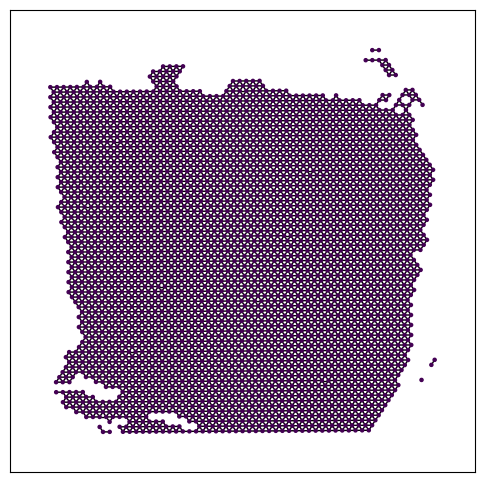

In [2]:
adata = sc.read_h5ad('/home/wcx99075523/Experiments/STForte/data/DLPFC/151673_10xvisium.h5ad')
d = adata.uns['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres']
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    coor_loc=['obsm','spatial'], 
    d=d
)
stgraph.visualize()

d-based initialize:   0%|          | 0/2518 [00:00<?, ?it/s]

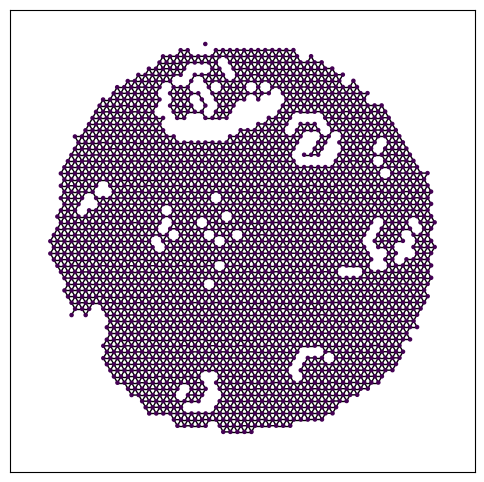

In [3]:
adata = sc.read_h5ad('/home/wcx99075523/Experiments/STForte/data/BRAC/Human_Breast_Cancer_Ductal_10xvisium.h5ad')
d = adata.uns['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres']
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    coor_loc=['obsm','spatial'], 
    d=d
)
stgraph.visualize()

### ST-data with spots of nearly inerratic lattices
StGraph require specified n_adj and d_eps parameters for graph construction under this condition.

**n_adj**: the expected number of neighbors of each spots. (e.g. A regular setting for nearly inerratic lattice ST data is 4. Besides, if sudo nodes are desired to be generated along every diagnoals of spots formed squares, this n_adj should be 8 for ST data.)

**d_eps**: the maximum tolerance for the difference among edge length. (e.g. For ST data, a normal setting is $1.5*d^{*}<d_{eps}<2*d^{*}$. Where $d^{*}$ is the average edge length.)

To get a better graph structure, you should try on different settings of **d_eps**

Infered d value: 1.1011357772772625


d-based initialize:   0%|          | 0/231 [00:00<?, ?it/s]

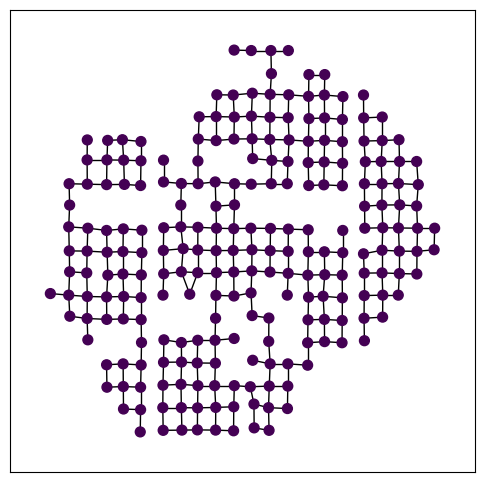

In [4]:
adata = sc.read_h5ad('/home/wcx99075523/Experiments/STForte/data/OFB/OFB_ad_rep1_ST.h5ad')
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    coor_loc=['obsm','spatial'],
    n_adj=4,
    d_eps=0.1
)
stgraph.visualize(node_size=50)

### ST-data with spots of iregular lattices
Usually under this condition, we suggest to construct StGraph through KNN stategy, which requires specified parameter k.

brute-force knn initialize:   0%|          | 0/19527 [00:00<?, ?it/s]

Graph construction uses 18.2411s


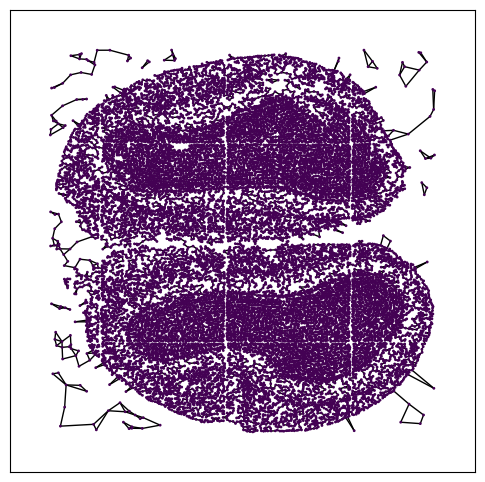

In [5]:
adata = sc.read_h5ad('/home/wcx99075523/Experiments/STForte/data/olfa-stereoseq/olfactory_buble.h5ad')
t = time.time()
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    coor_loc=['obs','x','y'],
    knn=True,
    k=2,    # Example k=2 is used for better visualization. Larger k is usually used in real experiments
    padding=False
)
print("Graph construction uses {:.4f}s".format(time.time() - t))
stgraph.visualize(node_size=1)

For faster construction, STGraph support KD-tree based KNN initialization

In [6]:
t = time.time()
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    coor_loc=['obs','x','y'],
    knn=True,
    kdtree=True,
    k=2,    # Example k=2 is used for better visualization. Larger k is usually used in real experiments
    padding=False
)
print("Graph construction uses {:.4f}s".format(time.time() - t))

KDTree knn innitialize.
Graph construction uses 2.0058s


## Padding
Automatically generate new spots at the centers of edges constructed under original resoltion. This operationis suggested to used when the graph struction method used under original resoltion is distance based other than KNN. 

d-based initialize:   0%|          | 0/2518 [00:00<?, ?it/s]

d-based initialize:   0%|          | 0/9563 [00:00<?, ?it/s]

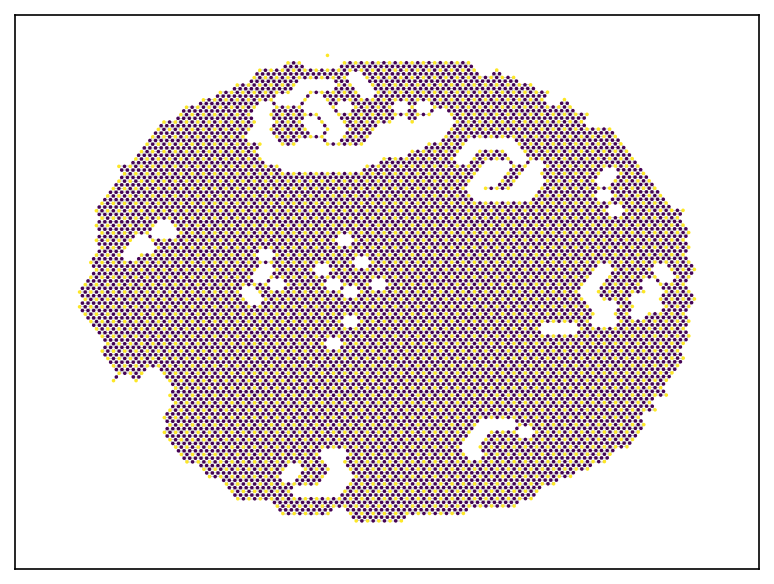

In [7]:
adata = sc.read_h5ad('/home/wcx99075523/Experiments/STForte/data/BRAC/Human_Breast_Cancer_Ductal_10xvisium.h5ad')
d = adata.uns['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres']
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    coor_loc=['obsm','spatial'], 
    d=d
)
stgraph.padding()
stgraph.visualize(node_size=0.5,kwargs=dict(width=0.1),fig_kwargs=dict(dpi=150)) # yellow nodes indecate the padded spots

Customers could use KNN to reconstruct the graph structure after padding

d-based initialize:   0%|          | 0/2518 [00:00<?, ?it/s]

brute-force knn initialize:   0%|          | 0/9563 [00:00<?, ?it/s]

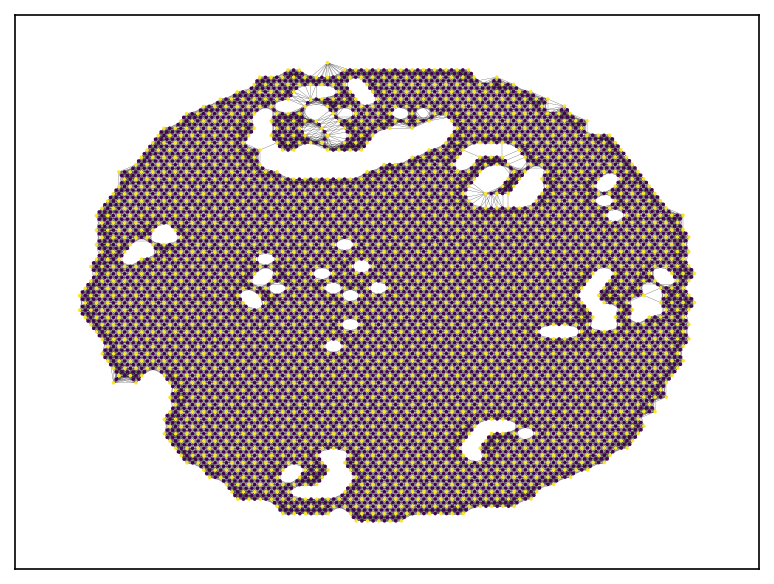

In [8]:
adata = sc.read_h5ad('/home/wcx99075523/Experiments/STForte/data/BRAC/Human_Breast_Cancer_Ductal_10xvisium.h5ad')
d = adata.uns['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres']
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    coor_loc=['obsm','spatial'], 
    d=d
)
stgraph.padding(reconstruct_knn=True,reconstruct_k=15)
stgraph.visualize(node_size=0.5,kwargs=dict(width=0.1),fig_kwargs=dict(dpi=150)) # yellow nodes indecate the padded spots

Remember to remove duplicating nodes after padding when data is non-regular lattice (using infered d when constructing graph at original resolution). The control parmeter r is set to 0.2 by default, which will remove one node from each node pairs that distance between two nodes is less than $d^{*}*r$. 

Infered d value: 1.1011357772772625


d-based initialize:   0%|          | 0/231 [00:00<?, ?it/s]

d-based initialize:   0%|          | 0/575 [00:00<?, ?it/s]

Detecting duplicates:   0%|           [ time left: ? ]

d-based initialize:   0%|          | 0/575 [00:00<?, ?it/s]

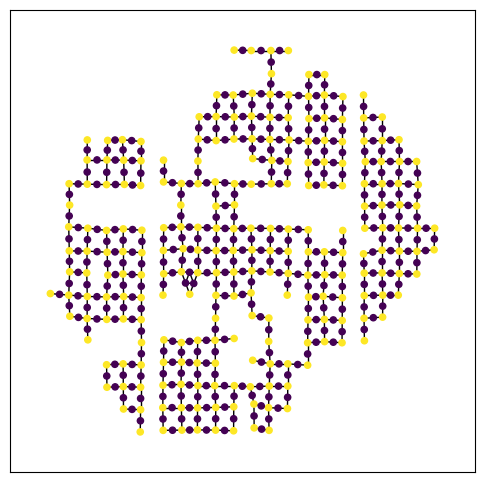

In [9]:
# with n_adj=4
adata = sc.read_h5ad('/home/wcx99075523/Experiments/STForte/data/OFB/OFB_ad_rep1_ST.h5ad')
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    coor_loc=['obsm','spatial'],
    n_adj=4,
    d_eps=0.1
)
stgraph.padding()
stgraph.remove_duplicates()
stgraph.visualize(node_size=20)

For data of irregular lattice, d-based initialization and padding is also allowed.

d-based initialize:   0%|          | 0/231 [00:00<?, ?it/s]

d-based initialize:   0%|          | 0/1008 [00:00<?, ?it/s]

Detecting duplicates:   0%|           [ time left: ? ]

d-based initialize:   0%|          | 0/827 [00:00<?, ?it/s]

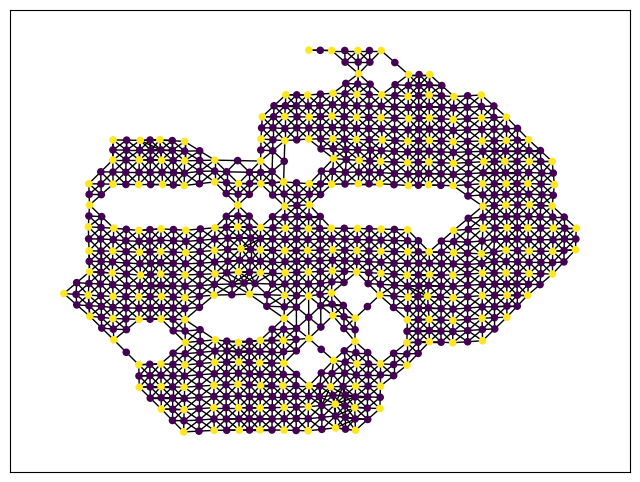

In [10]:
# to achieve approximate n_adj=8
adata = sc.read_h5ad('/home/wcx99075523/Experiments/STForte/data/OFB/OFB_ad_rep1_ST.h5ad')
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    coor_loc=['obsm','spatial'],
    d=1.9
)
stgraph.padding()
stgraph.remove_duplicates(r=0.3)
stgraph.visualize(node_size=20, fig_kwargs=dict(figsize=(8,6)))

## StGraph properties
### Basic graph properties could be automatically calculated by StGraph including:
                            Obj attribute(np.ndarray)
    node attributes         stgraph.node_attr
    node coor               stgraph.node_coor
    node id                 stgraph.node_id
    node state              stgraph.node_stat
    node label              stgraph.node_label
    adjacency matrix        strgaph.A
    edge list               strgaph.E_list
    edge attributes         stgraph.E_attr    

### Reduction methods
STGraph provide tree reduction methods: **PCA, CA, and scVI**. Applying these methods will directly change the node attribute. If you want to keep the original node attributes e.g. the raw count of expressions, please set the **in_place** parameter to false. 

In [11]:
adata = sc.read_h5ad('/home/wcx99075523/Experiments/STForte/data/OFB/OFB_ad_rep1_ST.h5ad')
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    coor_loc=['obsm','spatial'],
    n_adj=4,
    d_eps=0.1
)

# apply PCA reduction
stgraph.pca(n_components=50, in_place=False)
# apply CA reduction
stgraph.ca(n_components=50, in_place=False)
# apply scVI reduction
stgraph.scvi(in_place=False)

print("PCA result:\n", stgraph.get_additinal_notes("node_attr_PCA")[:3,:4])
print("CA result:\n", stgraph.get_additinal_notes("node_attr_CA")[:3,:4])
print("scVI result:\n", stgraph.get_additinal_notes("node_attr_scvi")[:3,:4])

Infered d value: 1.1011357772772625


d-based initialize:   0%|          | 0/231 [00:00<?, ?it/s]

PCA pre-compression for data, from 15859 onto 50-dim.
Scaling data: None; SVD solver: full; random_state=42.
Start compression...	Done! Elapsed time: 0.67s.
SVD solver: full; random_state=42.
Start compression...	

Global seed set to 0


Done! Elapsed time: 0.55s.
SCVI pre-compression for data.


{'n_hidden': 256, 'n_latent': 64, 'n_layers': 2}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [00:16<00:00, 33.45it/s, loss=8.02e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:16<00:00, 24.91it/s, loss=8.02e+03, v_num=1]
PCA result:
 [[ 2.8651471e+00  5.4917407e-01 -1.2811360e+00 -8.9514732e+01]
 [ 4.2862215e+00 -3.4839764e-01  1.2032181e-01 -8.2195618e+01]
 [ 2.1792879e+00 -9.4544120e-02  4.5801502e-02 -9.1805603e+01]]
CA result:
 [[ 0.06134554 -0.04993179  0.07727712  0.06578904]
 [ 0.06124268 -0.05281712  0.0767696   0.06861751]
 [ 0.06131735 -0.05272862  0.07786682  0.06872339]]
scVI result:
 [[-1.5750239  -2.3908062   1.4223061  -1.6185796 ]
 [ 1.9967253   1.4391996   0.6358184   0.04711232]
 [-0.761447    0.5082606   0.59594035  0.21423224]]


### Mask operations
STGraph support manually assign nodes as unobserved typpe by their node ids or sptial locations.

d-based initialize:   0%|          | 0/2518 [00:00<?, ?it/s]

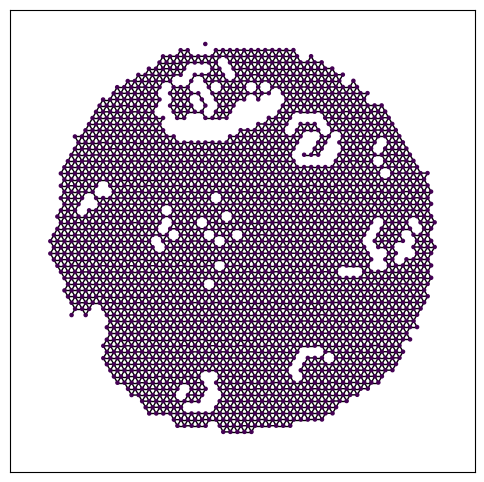

In [12]:
adata = sc.read_h5ad('/home/wcx99075523/Experiments/STForte/data/BRAC/Human_Breast_Cancer_Ductal_10xvisium.h5ad')
d = adata.uns['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres']
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    coor_loc=['obsm','spatial'], 
    d=d
)
stgraph.visualize()

Masking nodes by specify a polygen region with the indices of its verticies (clockwise/conter-clockwise)

Creating mask indexes:   0%|          | 0/2518 [00:00<?, ?it/s]

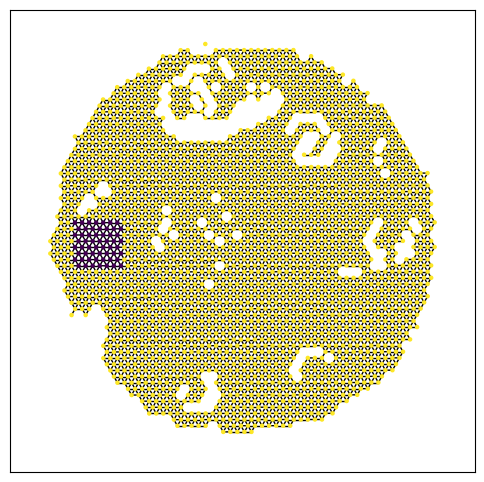

In [13]:
stgraph.mask_nodes(
    mask_vert_x = [7000,9000,9000,7000],
    mask_vert_y = [12000,12000,14000,14000]
)
stgraph.visualize()

Mask nodes with specific indices

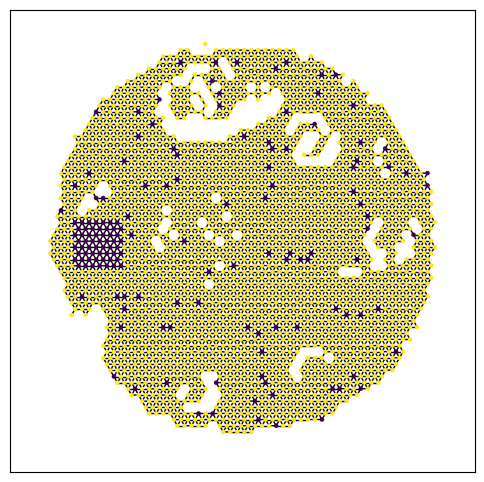

In [14]:
stgraph.mask_nodes(mask_idx=np.arange(100))
stgraph.visualize()

### Transform to PyG data type
STGraph provide method to directly transform into PyG data type for GNN training. However, this transformation will only use features that are not saved in stgraph.additional_notes, please assign the correct feature to stgraph attributes if you want to use features saved in additional notes before coverting into PyG data.

In [15]:
# StGraph to pyg.data
gdata = stgraph.topyg()
gdata

Data(x=[2518, 17651], xfp=[2518, 17651], adj_t=[2518, 2518, nnz=14090], inv_dist=[14090], value_idx=[2362], infer_idx=[156], coord=[2518, 2], x_id=[2518], mask_idx=[156])